In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

import pickle
from sklearn.metrics import f1_score, roc_curve, auc

from xgboost import XGBClassifier
import seaborn as sns 
import matplotlib.pyplot as plt

## Load dataset

In [2]:
data = pd.read_csv('Melanin_class.csv')
data.head(3)

,SMILES,Melanin,Class
0,CCN(CC)CCNC(=O)c1ccc(cc1)N.Cl,1.7,1
1,COCCNC(=O)CN1C2CCC1CC(C2)(c3cccnc3)O,38.7,1
2,CC1=NN=C(c2cc3c(cc2C1)OCO3)c4ccc(cc4)N,10.5,1


In [3]:
smiles = data['SMILES'].to_list()

### Convert SMILES to MACCS fingerprints

In [4]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df = pd.DataFrame(MACCS_list,columns=header)
df.insert(loc=0, column='SMILES', value=smiles)

### Split data into predictor and target

In [5]:
X = df.iloc[:, 1:168].astype(int)
y = data['Class']

In [6]:
X.shape

(780, 167)

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

### Fit the model

In [9]:
model = XGBClassifier(random_state=10).fit(Xtrain, ytrain)

In [10]:
model.score(Xtest, ytest)

0.7564102564102564

In [11]:
model.score(Xtrain, ytrain)

0.9967948717948718

Overfitting is observed

### Hyperparameter optimization

In [30]:
def hyperParameterTuning(X_train, y_train):

    param_tuning = { 
        'learning_rate': [0.01, 0.1, 0.2], 
        'max_depth': [2, 3, 5], 
        'min_child_weight': [5, 10], 
        'subsample': [0.5, 0.7, 1], 
        'colsample_bytree': [0.1, 0.3]
    } 

    xgb_model = XGBClassifier(random_state=10) 

    gsearch = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_tuning,
                           scoring='neg_mean_squared_error',  
                           cv=10, 
                           n_jobs=-1, 
                           verbose=1) 

    gsearch.fit(X_train, y_train) 

    return gsearch.best_params_

In [31]:
hyperParameterTuning(Xtrain, ytrain)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


{'colsample_bytree': 0.3,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 0.5}

### Train model with optimized hyperparameters

In [8]:
opt_model = XGBClassifier(colsample_bytree = 0.3,
                                learning_rate = 0.1,
                                max_depth = 5,
                                min_child_weight = 5,
                                subsample = 0.5,
                                random_state=10)
opt_model.fit(Xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=10, ...)

In [9]:
opt_model.score(Xtest, ytest)

0.7692307692307693

In [10]:
opt_model.score(Xtrain, ytrain)

0.8894230769230769

### Visualizing of model performance

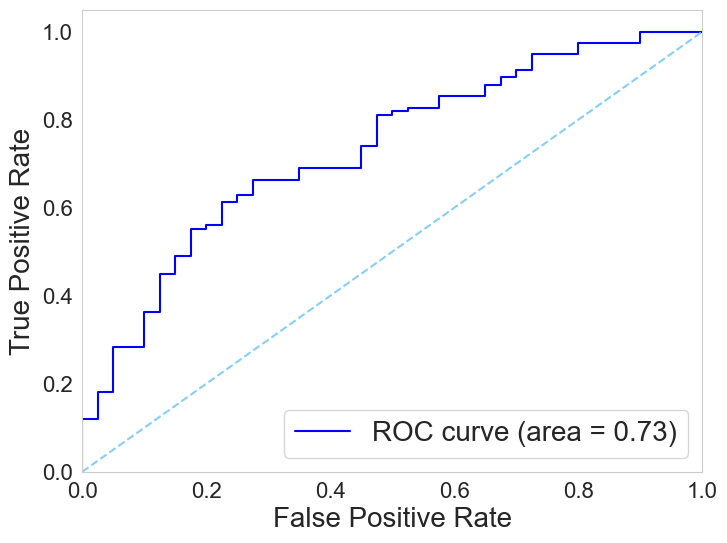

In [19]:
# Predict probabilities for the test set
y_pred = opt_model.predict_proba(Xtest)[:, 1]

fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='#87CEFA', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc='lower right', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.grid()
plt.savefig('melanin_ML.svg', dpi=700, bbox_inches='tight')
plt.show()

### Feature importance analysis

In [12]:
importance = opt_model.feature_importances_

In [13]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [14]:
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.03]

In [15]:
filtered_importance_df

,Feature,Importance
125,bit125,0.036691
98,bit98,0.034686
145,bit145,0.033549
124,bit124,0.033382


C:\Users\Anastasia\AppData\Local\Temp\ipykernel_15300\554617036.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')


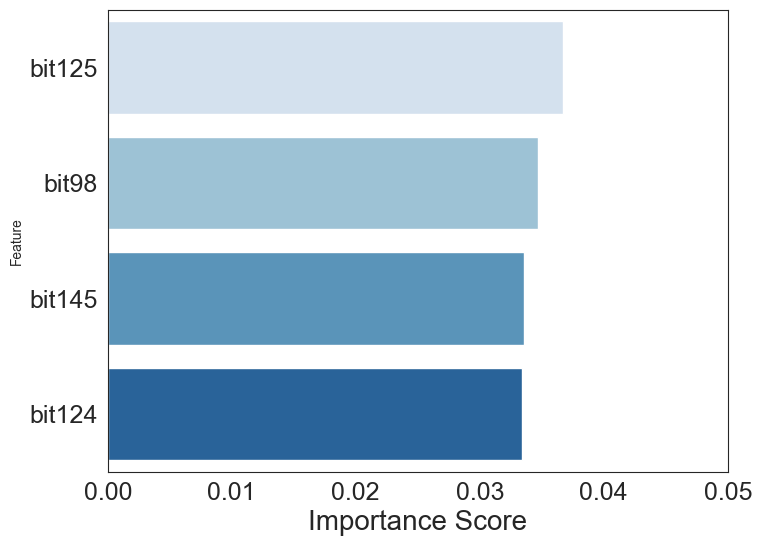

In [17]:
sns.set_style("white")

plt.figure(figsize=(8, 6))


sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')
sns.set_style("whitegrid")
plt.xlim(0, 0.05)
plt.xlabel('Importance Score', fontsize = 20)
plt.tick_params(axis='both', labelsize=18)

plt.savefig('FI_melanin.svg', dpi=700)
plt.show()

### Save model

In [ ]:
opt_model.save_model('melanin.json')